In [46]:
from lib.dataloader import get_data_loaders
from lib.models import SNN, LoRA_SNN
from lib.train import train
from lib.visualize import plot_losses, plot_accs
from lib.test import test
from lib.save import save
from lib.parameters_info import count_all_parameters, count_lora_parameters

import os

import torch
import torch.nn as nn


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 5

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Task identifiers
task_1 = "task_1"
task_2 = "task_2"

In [34]:
path = os.path.dirname(os.path.abspath("__file__"))

## Get Data

In [10]:
data_path = path + "\\data"

In [18]:
# Get data for task 1
class_names_1 = [0, 1, 2, 3, 4]
train_loader_1, val_loader_1, test_loader_1 = get_data_loaders(data_path, class_names_1, batch_size)

In [19]:
# Get data for task 2
class_names_2 = [5, 6, 7, 8, 9]
train_loader_2, val_loader_2, test_loader_2 = get_data_loaders(data_path, class_names_2, batch_size)

## Train vanilla SNN on task 1

In [20]:
task = task_1
train_loader = train_loader_1
val_loader = val_loader_1

In [23]:
snn_model = SNN(num_inputs, num_hidden, num_outputs, beta, num_steps).to(device)

In [29]:
dtype = torch.float
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

In [30]:
output = train(snn_model, task, dtype, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device, comp_val_loader=None)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = output

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.23s/it]

50 batches used in epoch 1
100 batches used in epoch 1
150 batches used in epoch 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:52<01:17, 25.88s/it]

50 batches used in epoch 2
100 batches used in epoch 2
150 batches used in epoch 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:17<00:51, 25.67s/it]

50 batches used in epoch 3
100 batches used in epoch 3
150 batches used in epoch 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:42<00:25, 25.48s/it]

50 batches used in epoch 4
100 batches used in epoch 4
150 batches used in epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


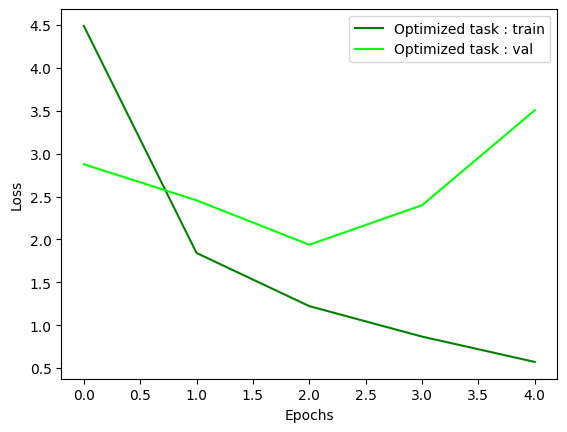

In [32]:
plot_losses(train_loss_hist, val_loss_hist)

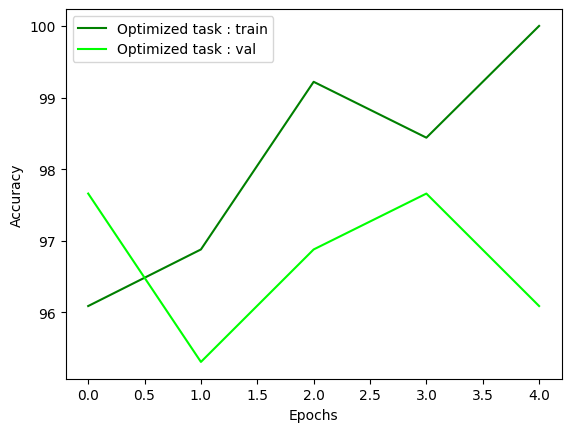

In [33]:
plot_accs(train_acc_hist, val_acc_hist)

## Save vanilla SNN

In [42]:
model_path = path + "\\SNN_LoRA/state_dict.pth"

In [43]:
save(model_path, snn_model)

## Load LoRA SNN

In [44]:
lora_rank = 32

In [45]:
lora_snn_model = LoRA_SNN(lora_rank, model_path, num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps).to(device)

In [47]:
print("Number of none LoRA parameters of the linear layers (not trainable):", count_all_parameters(lora_snn_model))
print("Number of parameters introduced by LoRA (trainable):", count_lora_parameters(lora_snn_model))

Number of none LoRA parameters of the linear layers (not trainable): 790005
Number of parameters introduced by LoRA (trainable): 89248


## Test vanilla SNN

In [48]:
# So far, lora_snn_model is simply our trained vanilla SNN

In [49]:
print(f"vanilla SNN model achieves {test(lora_snn_model, test_loader_1, task_1, batch_size, device)}% accuracy on task 1")
print(f"vanilla SNN model achieves {test(lora_snn_model, test_loader_2, task_2, batch_size, device)}% accuracy on task 2")

vanilla SNN model achieves 97.3% accuracy on task 1
vanilla SNN model achieves 34.88% accuracy on task 2


## Train LoRA SNN on task 2

In [50]:
task = task_2
train_loader = train_loader_2
val_loader = val_loader_2
comp_val_loader = val_loader_1

In [54]:
optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
num_epochs = 1

In [55]:
output = train(lora_snn_model, task, dtype, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device, comp_val_loader=comp_val_loader)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist, comp_val_loss_hist, comp_val_acc_hist = output

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.40s/it]


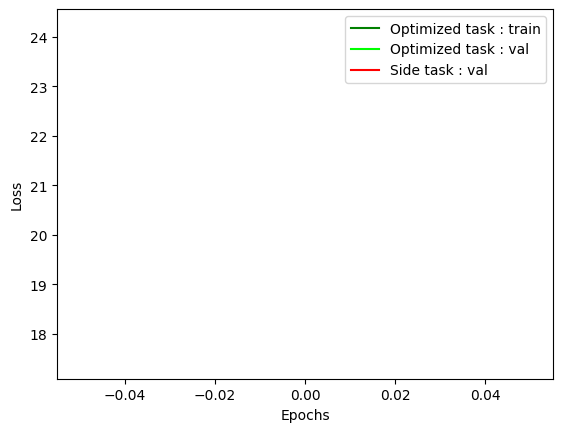

In [56]:
plot_losses(train_loss_hist, val_loss_hist, comp_val_loss_hist)

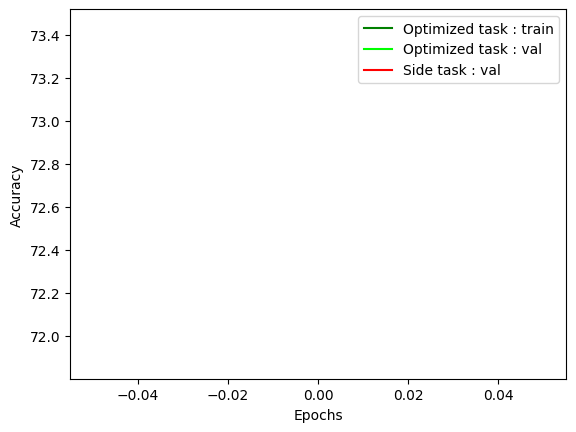

In [57]:
plot_accs(train_acc_hist, val_acc_hist, comp_val_acc_hist)

## Test LoRA SNN on both tasks

In [58]:
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_1, task_1, batch_size, device)}% accuracy on task 1")
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_2, task_2, batch_size, device)}% accuracy on task 2")

lora_snn_model achieve 72.07% accuracy on task 1
lora_snn_model achieve 71.66% accuracy on task 2
